### Simple Transformer test to train to predict Bitcoin price direction

In [15]:
# Created by Davide Pasca - 2023/07/31

# Ensure that the notebook can see the data dir (Google Colab only)
import os
def is_colab():
  try:
    import google.colab
    return True
  except ImportError:
    return False

if is_colab():
  repo = 'dpasca-pytorch-examples'
  full_path = f'/content/drive/MyDrive/dev/repos/{repo}'

  if os.getcwd() != full_path:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd {full_path}

  %pwd

import torch
import torch.nn as nn
import torch.optim as optim
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from typing import Tuple

In [16]:
import subprocess
import torch

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    #print(subprocess.check_output(["nvidia-smi"], encoding="utf-8").strip())
    print(subprocess.check_output(["nvidia-smi", "-L"], encoding="utf-8").strip())
    print("Torch CUDA version:", torch.version.cuda)
elif torch.backends.mps.is_available():
    device = "mps"

print("Using device:", device)

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-bbc25c21-c112-d2b6-97e1-493b90d9f22a)
Torch CUDA version: 11.8
Using device: cuda


In [17]:
# Constants

SAMPLE_SIZE_HOURS = int(4)
SAMPLE_SIZE_MINS = 60 * SAMPLE_SIZE_HOURS  # 6 hours

USE_LOG_RETURNS = True

EPOCHS_N = 5000
BATCH_SIZE = 128

# Gradient accumulation steps
ACCUMULATION_STEPS = 10

# Define the thresholds for buying and selling
BUY_THRESHOLD  = 1+0.010
SELL_THRESHOLD = 1-0.010

USE_HOLD_CLASS = True

CLASSES_N = 3 if USE_HOLD_CLASS else 2

USE_WEIGHTED_LOSS = True

LOOK_FORWARD_SAMP_N = 8*60 // SAMPLE_SIZE_MINS # 24 hours

if False: # quick test
    SEQUENCE_LENGTH_MINS = 1*24*60 # days * 24 * 60
    SEQUENCE_LENGTH = SEQUENCE_LENGTH_MINS // SAMPLE_SIZE_MINS
    TRAIN_DATES = ['2020-01-01', '2022-12-31']
    TEST_DATES  = ['2023-01-01', '2023-07-23']
else:
    SEQUENCE_LENGTH_MINS = 5*24*60 # days * 24 * 60
    SEQUENCE_LENGTH = SEQUENCE_LENGTH_MINS // SAMPLE_SIZE_MINS
    TRAIN_DATES = ['2017-01-01', '2022-12-31']
    TEST_DATES  = ['2023-01-01', '2023-07-23']

print(f'BUY_THRESHOLD: {BUY_THRESHOLD}, SELL_THRESHOLD: {SELL_THRESHOLD}')
print(f'LOOK_FORWARD_SAMP_N: {LOOK_FORWARD_SAMP_N}')
print(f'SAMPLE_SIZE_HOURS: {SAMPLE_SIZE_HOURS}')
print(f'ACCUMULATION_STEPS: {ACCUMULATION_STEPS}')
print(f'SEQUENCE_LENGTH: {SEQUENCE_LENGTH}')
print(f'TRAIN_DATES: {TRAIN_DATES}')
print(f'TEST_DATES: {TEST_DATES}')

# Define a mapping from labels to integers
if USE_HOLD_CLASS:
    LABELS_TO_INT_CLASS = {'Buy': 0, 'Sell':  1, 'Hold': 2}
    LABELS_TO_INT_DISP  = {'Buy': 1, 'Sell': -1, 'Hold': 0}
    CLASS_TO_DISP = {0: 1, 1: -1, 2: 0}
else:
    LABELS_TO_INT_CLASS = {'Buy': 0, 'Sell':  1}
    LABELS_TO_INT_DISP  = {'Buy': 1, 'Sell': -1}
    CLASS_TO_DISP = {0: 1, 1: -1}

BUY_THRESHOLD: 1.01, SELL_THRESHOLD: 0.99
LOOK_FORWARD_SAMP_N: 2
SAMPLE_SIZE_HOURS: 4
ACCUMULATION_STEPS: 10
SEQUENCE_LENGTH: 30
TRAIN_DATES: ['2017-01-01', '2022-12-31']
TEST_DATES: ['2023-01-01', '2023-07-23']


In [18]:
import requests
import json
import time
import datetime

def get_klines_req(symbol, interval, start_time, limit=500):
    url = 'https://api.binance.com/api/v3/klines'

    # Define the parameters
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'limit': limit
    }

    response = requests.get(url, params=params)
    data = json.loads(response.text)

    # Convert the data to a more readable format
    readable_data = []
    for candle in data:
        time_stamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(candle[0]/1000))
        ohlcv = candle[1:6]
        readable_candle = [time_stamp] + ohlcv
        readable_data.append(readable_candle)

    return readable_data

def get_klines(symbol, interval, start_date, end_date):
    # Convert the start and end dates to milliseconds
    start_time = int(start_date.timestamp() * 1000)
    end_time = int(end_date.timestamp() * 1000)

    # Fetch historical data for Bitcoin with 6 hours candles
    btc_data = []
    while True:
        new_data = get_klines_req(symbol, interval, start_time)
        if not new_data:
            break
        last_time = new_data[-1][0]
        last_time_dt = datetime.datetime.strptime(last_time, '%Y-%m-%d %H:%M:%S')
        last_time_millis = int(last_time_dt.timestamp() * 1000)
        if last_time_millis >= end_time:
            # Clamp candles that go beyond the end date
            new_data = [candle for candle in new_data if int(datetime.datetime.strptime(candle[0], '%Y-%m-%d %H:%M:%S').timestamp() * 1000) < end_time]
        btc_data += new_data
        if last_time_millis >= end_time:
            break
        start_time = last_time_millis + 1
        time.sleep(0.1)  # delay to avoid hitting rate limits

    return btc_data

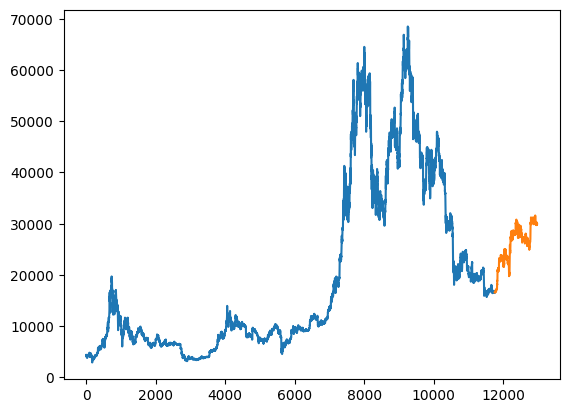

In [19]:
import os
import pickle

def get_closing_prices_in_range(res : str, datesYMD : list):
    start_YMD, end_YMD = datesYMD
    start_date = datetime.datetime.strptime(start_YMD, '%Y-%m-%d')
    end_date = datetime.datetime.strptime(end_YMD, '%Y-%m-%d')

    # Create a cache directory if it doesn't exist
    cache_dir = 'market_data_cache'
    os.makedirs(cache_dir, exist_ok=True)

    # Create a cache file name based on the start and end dates
    cache_file = os.path.join(cache_dir,
                        'btc_usdt_{}_binance_data_{}_{}.pickle'
                        .format(res, start_YMD, end_YMD))

    # Check if the cache file exists
    if os.path.exists(cache_file):
        # If the cache file exists, load the data from the file
        with open(cache_file, 'rb') as f:
            btc_data = pickle.load(f)
    else:
        # If the cache file doesn't exist, fetch the data and save it to the cache file
        btc_data = get_klines('BTCUSDT', res, start_date, end_date)
        with open(cache_file, 'wb') as f:
            pickle.dump(btc_data, f)

    return [float(candle[4]) for candle in btc_data]

# Split the data into training and test sets
resolution = str(SAMPLE_SIZE_HOURS) + 'h'
train_y = torch.tensor(get_closing_prices_in_range(resolution, TRAIN_DATES))
test_y  = torch.tensor(get_closing_prices_in_range(resolution, TEST_DATES))

# plot train and test data
plt.plot(train_y, label='Train Data')
plt.plot(range(len(train_y), len(train_y) + len(test_y)), test_y, label='Test Data')
plt.show()

In [20]:
def create_sequences(input_data, seq_length, for_labels=False):
    sequences = []

    if for_labels:
        use_input_data = input_data
    else:
        if USE_LOG_RETURNS:
            # Compute the log returns. We'll shift the input data by 1 element to compute the difference in logs.
            use_input_data = torch.log(input_data[1:]) - torch.log(input_data[:-1])
            # Normalize log returns
            use_input_data = (use_input_data - torch.mean(use_input_data)) / torch.std(use_input_data)
        else:
            use_input_data = (input_data - torch.mean(input_data)) / torch.std(input_data)

    # The 'unfold' function is used to create sliding windows over the data.
    #   1st argument is the dimension along which to unfold (0: time dimension)
    #   2nd argument is the size of each slice (seq_length + 1)
    #     We add 1 because each sequence consists of 'seq_length' elements plus 1 label.
    #   3rd argument is the step between each slice (1)
    #     This means that each sequence will start 1 time step after the prev sequence
    seq = use_input_data.unfold(0, seq_length + 1, 1)

    # 'seq' is now a 2D tensor where each row is a sequence.
    # We can convert it back to a list of sequences using a list comprehension
    # For each sequence in 'seq', we treat the last element as the label and the rest as the input sequence
    # So, s[:-1] is the input sequence and s[-1] is the label.
    sequences = [(s[:-1], s[-1]) for s in seq]

    return sequences

# input sequences here are the raw prices, no log returns, no normalization
def label_sequences(sequences, look_forward=5):
    labeled_sequences = []

    for i in range(len(sequences) - look_forward):
        current_sequence, current_price = sequences[i]
        next_price = sequences[i + look_forward][1]

        # Calculate the percentage return
        #percent_return = (next_price - current_price) / current_price
        nav = next_price / current_price

        # Assign a label based on the percentage return
        if USE_HOLD_CLASS:
            if nav > BUY_THRESHOLD:
                label = 'Buy'
            elif nav < SELL_THRESHOLD:
                label = 'Sell'
            else:
                label = 'Hold'
        else:
            if nav > BUY_THRESHOLD:
                label = 'Buy'
            else:
                label = 'Sell'

        labeled_sequences.append((current_sequence, label))

    noop_class = 'Hold' if USE_HOLD_CLASS else 'Sell'
    # The last few sequences don't have enough following sequences, so we'll just set to default
    for i in range(len(sequences) - look_forward, len(sequences)):
        sequence, _ = sequences[i]
        labeled_sequences.append((sequence, noop_class))

    return labeled_sequences

def create_and_label_sequences(data, seq_length, look_forward):
    # Create sequences for labeling and model input
    labeling_sequences = create_sequences(data, seq_length, for_labels=True)
    input_sequences = create_sequences(data, seq_length, for_labels=False)
    # Label the sequences
    labeled_sequences = label_sequences(labeling_sequences, look_forward)
    # Combine input_sequences and labels
    sequences = [(input_seq, label) for ((input_seq, _), (_, label)) in zip(input_sequences, labeled_sequences)]

    return sequences

# do build the sequences, with labels, for training and testing
train_sequences = create_and_label_sequences(train_y, SEQUENCE_LENGTH, LOOK_FORWARD_SAMP_N)
test_sequences = create_and_label_sequences(test_y, SEQUENCE_LENGTH, LOOK_FORWARD_SAMP_N)

# Convert sequences directly to PyTorch tensors
train_sequence_data = [(seq.unsqueeze(1).float().to(device), torch.tensor(LABELS_TO_INT_CLASS[label]).to(device)) for seq, label in train_sequences]
test_sequence_data  = [(seq.unsqueeze(1).float().to(device), torch.tensor(LABELS_TO_INT_CLASS[label]).to(device)) for seq, label in test_sequences]

# print the shapes of the training and testing data
print(f"Train seq data size: {len(train_sequence_data)} * {train_sequence_data[0][0].shape}")
print(f"Test  seq data size: {len(test_sequence_data)} * {test_sequence_data[0][0].shape}")

Train seq data size: 11722 * torch.Size([30, 1])
Test  seq data size: 1187 * torch.Size([30, 1])


In [21]:
from torch.utils.data import DataLoader

# Create data loaders
train_dataloader = DataLoader(train_sequence_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_sequence_data, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
# TEST TEST TEST for create_sequences()
if True:
    test_input_data = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0])
    test_seq = create_sequences(test_input_data, 4, for_labels=True)
    for seq, label in test_seq:
        print(f"seq: {seq}, label: {label}")

seq: tensor([1., 2., 3., 4.]), label: 5.0
seq: tensor([2., 3., 4., 5.]), label: 6.0
seq: tensor([3., 4., 5., 6.]), label: 7.0
seq: tensor([4., 5., 6., 7.]), label: 8.0
seq: tensor([5., 6., 7., 8.]), label: 9.0


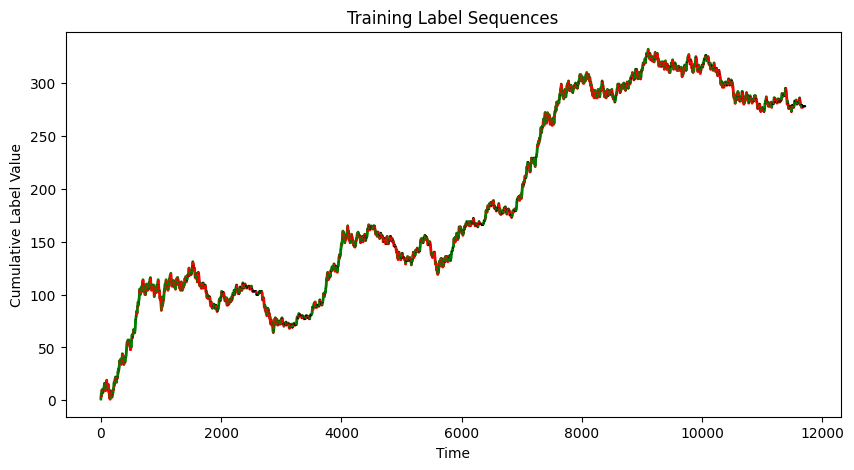

Occurrences of each label: Counter({'Hold': 6250, 'Buy': 2875, 'Sell': 2597})


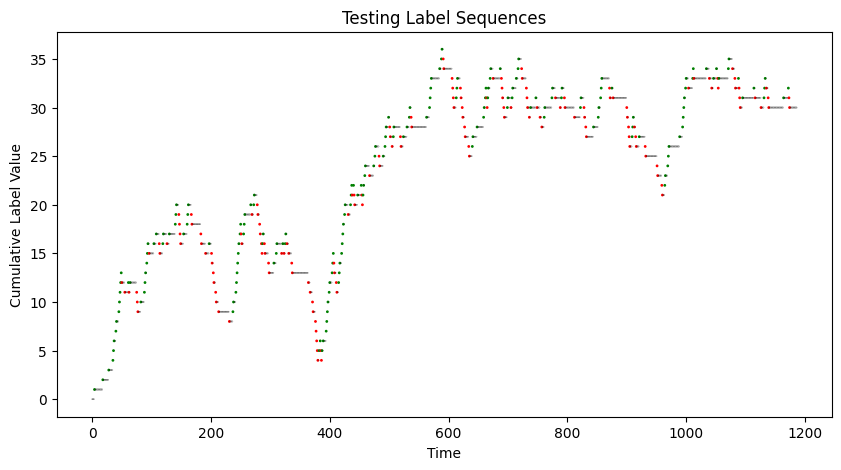

Occurrences of each label: Counter({'Hold': 849, 'Buy': 184, 'Sell': 154})


In [23]:
from collections import Counter

# TEST TEST TEST, visual inspection of labels
def plot_label_sequences(name : str, labels : list):
    # Convert the labels to integers using your defined mapping
    labels_int = [LABELS_TO_INT_DISP[label] for label in labels]

    # Compute the cumulative sum
    labels_cumulative = np.cumsum(labels_int)

    # Create a colormap
    colors = ['red' if label == -1 else 'black' if label == 0 else 'green' for label in labels_int]

    # Define sizes (smaller for 'Hold')
    sizes = [0.01 if label == 0 else 1 for label in labels_int]

    plt.figure(figsize=(10, 5))

    # Plot using plt.plot for better performance
    plt.scatter(range(len(labels_cumulative)), labels_cumulative, c=colors, s=sizes)

    plt.xlabel('Time')
    plt.ylabel('Cumulative Label Value')
    plt.title(f'{name} Label Sequences')
    plt.show()

    # Count the occurrences of each label
    label_counts = Counter(labels)
    print("Occurrences of each label:", label_counts)

if True:
    plot_label_sequences('Training', [label for _, label in train_sequences])
    plot_label_sequences('Testing',  [label for _, label in test_sequences])

In [24]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, output_dim=3, seq_len=50, num_layers=2, hidden_dim=128):
        super(TransformerModel, self).__init__()
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.transformer = nn.Transformer(
            d_model=hidden_dim,
            nhead=8, # number of features to attend to
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_dim,
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        x = self.embedding(x)
        tgt = torch.cat(
            [torch.zeros(1, x.size(1), self.hidden_dim, device=device), x[:-1,:,:]],
            dim=0)
        x = self.transformer(x, tgt)
        x = self.fc(x)  # Apply last layer, hidden_dim -> output_dim
        return x

model = TransformerModel(
    seq_len=SEQUENCE_LENGTH,
    output_dim=CLASSES_N)
model = model.to(device)

In [25]:
def print_report(
    epoch, epochs_n, epochs_per_sec, lr,
    train_losses, target_losses, test_dataloader, test_predictions):

    # Convert test_predictions to display values and make a copy
    test_predictions_disp = [CLASS_TO_DISP[pred] for pred in test_predictions[:]]

    # Create a figure with 2 subplots arranged vertically
    fig, axs = plt.subplots(2, 1, figsize=(18, 10), gridspec_kw={'height_ratios': [1, 2]})

    # Plot the actual values and the predictions
    actual_values = []
    for _, labels in test_dataloader:
        # convert with CLASS_TO_DISP for plotting
        labels_plot = [CLASS_TO_DISP[int(label.detach().cpu().numpy())] for label in labels]
        actual_values.extend(labels_plot)

    axs[0].plot(actual_values, label='Actual', marker='o', linestyle='', markersize=2)
    axs[0].plot(test_predictions_disp, label='Predicted', marker='x', linestyle='', markersize=2)
    axs[0].set_xlabel('Time Step')
    axs[0].set_ylabel('Class Label')
    axs[0].legend()
    axs[0].grid(True)

    # Plot losses
    axs[1].plot(train_losses, label='Train Loss')
    axs[1].plot(target_losses, label='Target Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()

    clear_output(wait=True)
    # make str of epochs per second or epoch per minute
    perf_str = (f'{epochs_per_sec:.3f}/sec' if epochs_per_sec > 1.0 else f'{60.0*epochs_per_sec:.3f}/min')
    print(f'Epoch {epoch+1}/{epochs_n} ({perf_str}),', end=' ')
    print(f'LR: {lr:.6f},', end=' ')
    print(f'Train loss: {train_losses[-1]:.5f},', end=' ')
    print(f'Target loss: {target_losses[-1]:.5f}')
    plt.show()

In [26]:
def calculate_weights(sequences):
    # Initialize counts
    if USE_HOLD_CLASS:
        counts = {'Buy': 0, 'Sell': 0, 'Hold': 0}
    else:
        counts = {'Buy': 0, 'Sell': 0}

    # Count occurrences of each class
    for _, label in sequences:
        counts[label] += 1

    # Calculate total number of labels
    total_count = sum(counts.values())

    # Calculate weights as inverse of counts
    weights = {label: total_count / count for label, count in counts.items()}

    return weights

# Calculate weights for training data
if USE_WEIGHTED_LOSS:
    weights = calculate_weights(train_sequences)
    print(f'Weights for classes: {weights}')
else:
    weights = {'Buy': 1, 'Sell': 1, 'Hold': 1}

# Convert weights to tensor and move to device
if USE_HOLD_CLASS:
    weights_tensor = torch.tensor([weights['Buy'], weights['Sell'], weights['Hold']]).float().to(device)
else:
    weights_tensor = torch.tensor([weights['Buy'], weights['Sell']]).float().to(device)

Weights for classes: {'Buy': 4.077217391304348, 'Sell': 4.513669618790913, 'Hold': 1.87552}


Epoch 5000/5000 (37.275/min), LR: 0.000005, Train loss: 1.04098, Target loss: 1.13358


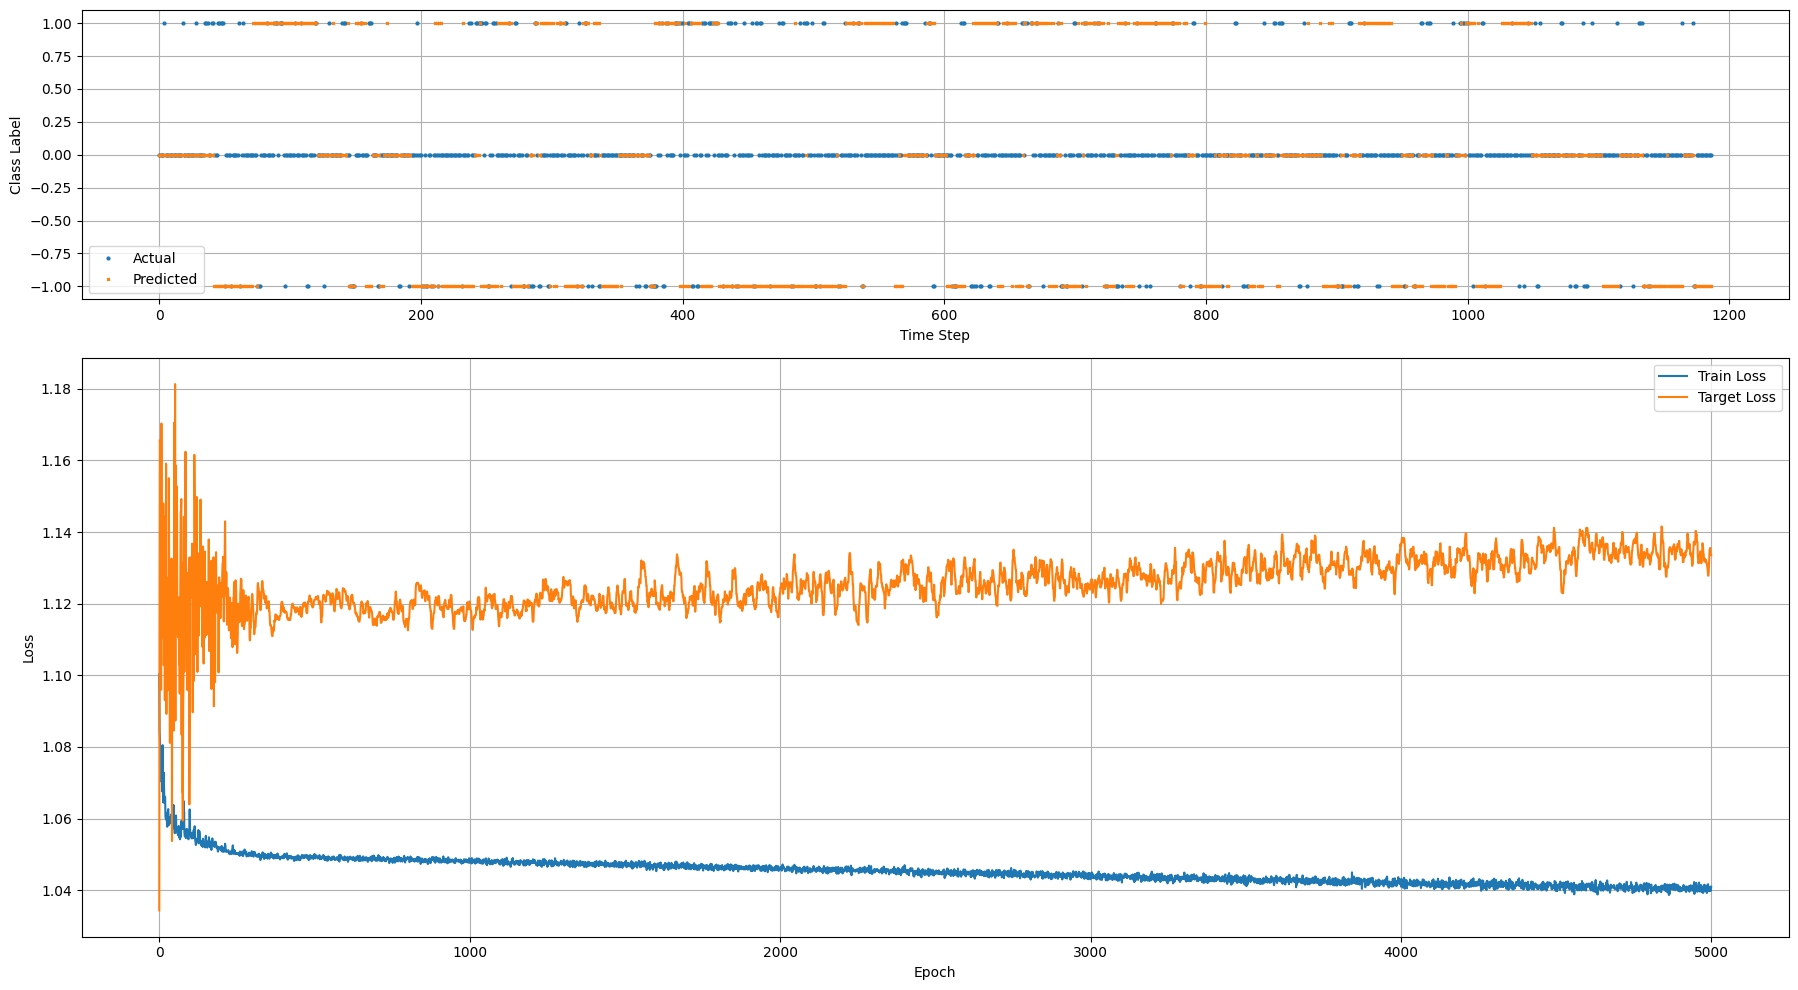

In [27]:
# torch seed to 0
torch.manual_seed(0)

# Create loss function with calculated weights
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=0.0005)

# Initialize the scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min',
    patience=10, factor=0.8, min_lr=5e-6)

# For storing losses
train_losses = []
target_losses = []

# For plotting losses
plt.ion()

last_update_time = time.time()
last_update_epoch = -1

for epoch in range(EPOCHS_N):
    train_loss = 0.0

    for i, (seq_batch, label_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()  # Reset the gradients
        output = model(seq_batch)  # Forward pass

        # Compute the loss, and sum the losses over the batch
        #print(f'Output shape: {output[:, -1, :].squeeze(-1).shape}, Label shape: {label_batch.squeeze(-1).shape}')
        loss = criterion(output[:, -1, :].squeeze(-1), label_batch.squeeze(-1))

        train_loss += loss.item() * seq_batch.size(0)  # Multiply by batch size

        loss.backward()  # Backpropagation

        # Update weights every ACCUMULATION_STEPS batches
        if (i+1) % ACCUMULATION_STEPS == 0 or (i+1) == len(train_dataloader):
            optimizer.step()  # Update the weights
            optimizer.zero_grad()  # Reset gradients

    # Average training loss for this epoch
    train_loss /= len(train_sequence_data)
    train_losses.append(train_loss)

    # update the scheduler
    scheduler.step(train_loss)

    # rest of the loop...
    is_edge_epoch = (epoch == 0 or epoch == EPOCHS_N - 1)

    # Compute loss on target data
    if is_edge_epoch or (epoch % 5):
        target_loss = 0
        model.eval() # eval mode !
        for seq_batch, label_batch in test_dataloader:
            output = model(seq_batch)
            # Compute the loss for the last element of each sequence
            target_loss += criterion(output[:, -1, :].squeeze(-1), label_batch.squeeze(-1)).item() * seq_batch.size(0)
        model.train() # back to train mode !
        target_loss /= len(test_sequence_data)
        target_losses.append(target_loss)
    else:
        # append the previous target loss
        target_losses.append(target_losses[-1])

    # Print losses
    cur_time = time.time()
    if cur_time > (last_update_time+5) or is_edge_epoch:
        dt = cur_time - last_update_time
        epochs_per_sec = ((epoch - last_update_epoch) / dt if dt > 0 else 0.0)
        last_update_time = cur_time
        last_update_epoch = epoch

        # Generate predictions on the test set
        model.eval() # eval mode !
        test_predictions = []
        for seq_batch, label_batch in test_dataloader:
            output = model(seq_batch)
            # store only the last prediction for each sequence
            # take the argmax to get the predicted class
            test_predictions.extend(torch.argmax(output[:, -1, :], dim=-1).detach().cpu().numpy())
        model.train() # back to train mode !

        print_report(
          epoch, EPOCHS_N, epochs_per_sec, optimizer.param_groups[0]['lr'],
          train_losses, target_losses, test_dataloader, test_predictions)

plt.ioff()